# Beautiful numbers - EDA

## Load libraries and data

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
# append the path of the parent directory
sys.path.append("..")
from lib.utils import *

In [88]:
df_raw = pd.read_csv("../data/raw/ventaNavidad.csv")

## Initial exploration

In [51]:
df_raw.info
df_raw.isna().sum()

# this is an extremely simple data frame. 
# there are no missing values and all the datatypes are int64. 
# we might want to change the data type of 'n' to 'string', as the number itself works as an id. 

year     0
n        0
sales    0
dtype: int64

### How are sales distributed per nr?  

Let's take a first look at the general distribution of sales per number along the years

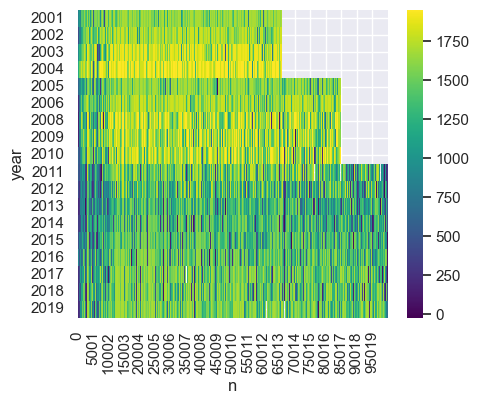

In [52]:
plt.clf()
sns.heatmap(df_raw.pivot(index="year", columns="n", values="sales"), cmap="viridis")
plt.show()

Nothing obvious emerges, besides the fact that not all numbers were put on sale until 2011. 
We'll filter the previous years out. And see if a scatter plot offer more info. 

<Axes: xlabel='n', ylabel='sales'>

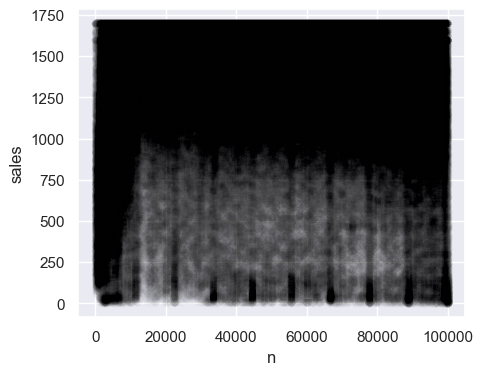

In [53]:
sns.scatterplot(data=df_raw[df_raw['year']>2012], x='n', y='sales', color = 'black', alpha=0.01)

Something is going on with this distribution. 
For comparison: this is what we'd expect if the lottery numbers were picked randomly. 

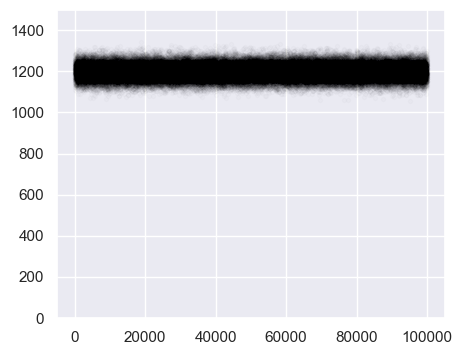

In [54]:
x = np.random.randint(0, 1e5-1, int(1.2e8))
plt.clf()
plt.plot(np.bincount(x), marker=".", linestyle="", color = 'black', alpha=0.01)
plt.ylim(0, 1500)
plt.show()

Some clear patterns emerge from the scatter plot.
 - on the left, the numbers starting with 0 seem to get less sales. 
 - after n = 10000, the sales seem to decrease slowly with n. 
 - there are 9 misterious columns separated with black lines... these lines might correspond to very repetitive numbers, similar to 11111, 22222 etc.
 - The available nr of series and numbers has changed over the years. We will need to normalise the dataset

<Axes: xlabel='year', ylabel='sales'>

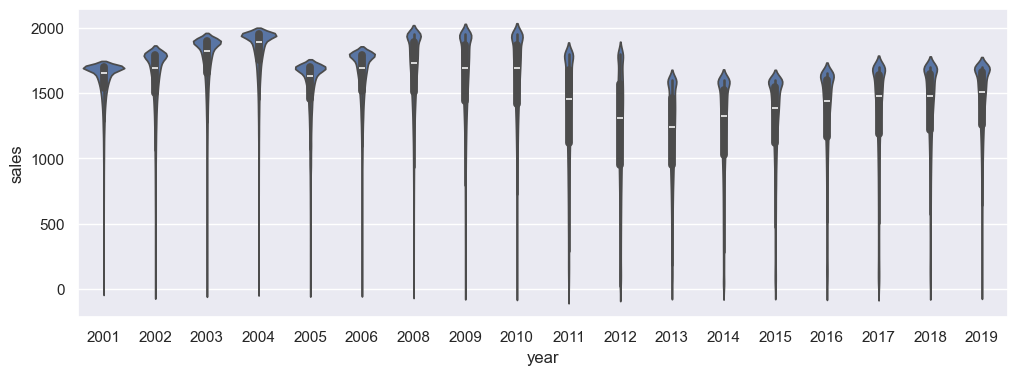

In [55]:
sns.set_theme(rc={'figure.figsize':(12,4)})

sns.violinplot(data=df_raw, x='year', y='sales')

Some insights:
- The sales distribution is truncated every year by certain maximun value (the total amount of lottery tickets issued per number).
- The distribution mode is usually equal to this max value (i.e: most nrs sell all their series and "décimos"). 
- Nonetheless, there's a long tail of nrs that fail to sell as much. This will give us more information about the so called "ugly numbers".
- The median amount of sales is lower than the mode although quite close to the higer values of each distribution. 

We could say that most of these distributions are quite saturated: since most of the nrs sell almost all of their "décimos", we cannot tell if they are all equally popular. It'd be interesting to know if some of these numbers are sold out much quicklier than others, but we don't have access to that information.

How many nrs sell all the available "décimos" every year?
- 537 nrs have sold all their tickets since 2001.  
- These are our beaty queens.

In [56]:
# how many tickets sell all their nrs?

total_sales = df_raw.groupby('n').sum()
total_sales[total_sales['sales'] == total_sales['sales'].max()]

,year,sales
n,,
1013,36183,31850
2413,36183,31850
2713,36183,31850
3513,36183,31850
5113,36183,31850
...,...,...
65313,36183,31850
65813,36183,31850
65957,36183,31850


### Year over year comparison

Is the year information relevant for our analysis? Let's analyse the YoY information. 

In [57]:
df_raw[['year', 'sales']].groupby('year').describe()

sales                                                               
         count         mean         std   min     25%     50%     75%     max
year                                                                         
2001   66000.0  1572.338076  203.112835   0.0  1534.0  1650.0  1700.0  1700.0
2002   66000.0  1581.279273  288.460701 -10.0  1500.0  1689.0  1790.0  1800.0
2003   66000.0  1713.025288  268.730056   0.0  1650.0  1818.0  1898.0  1900.0
2004   66000.0  1801.540242  223.086169   0.0  1750.0  1890.0  1950.0  1950.0
2005   85000.0  1512.282859  275.546087   0.0  1450.0  1630.0  1700.0  1700.0
2006   85000.0  1595.866212  270.359248   0.0  1511.0  1693.0  1790.0  1800.0
2008   85000.0  1639.308824  328.101100   0.0  1506.0  1730.0  1889.0  1950.0
2009   85000.0  1589.611294  376.663700   0.0  1440.0  1694.0  1870.0  1950.0
2010   85000.0  1569.375153  399.932983   0.0  1412.0  1687.0  1870.0  1950.0
2011   98948.0  1335.743421  427.931078 -22.0  1120.0  1450.0  1672.0  1800.0
2012   99999.0  1211.940689  456.582057   0.0   949.0  1306.0  1566.0  1800.0
2013  100000.0  1155.803170  385.088812   0.0   949.0  1243.0  1460.0  1600.0
2014   99977.0  1206.050592  398.885777   0.0  1027.0  1325.0  1522.0  1600.0
2015   99953.0  1256.867408  382.389965   0.0  1117.0  1385.0  1547.0  1600.0
2016   99975.0  1291.754109  410.640815   0.0  1163.0  1440.0  1595.0  1650.0
2017   99961.0  1323.101109  425.719347   0.0  1184.0  1474.0  1639.0  1700.0
2018   99855.0  1347.771459  395.401631   0.0  1213.0  1480.0  1641.0  1700.0
2019   99896.0  1380.231381  371.114193   0.0  1253.0  1506.0  1658.0  1700.0

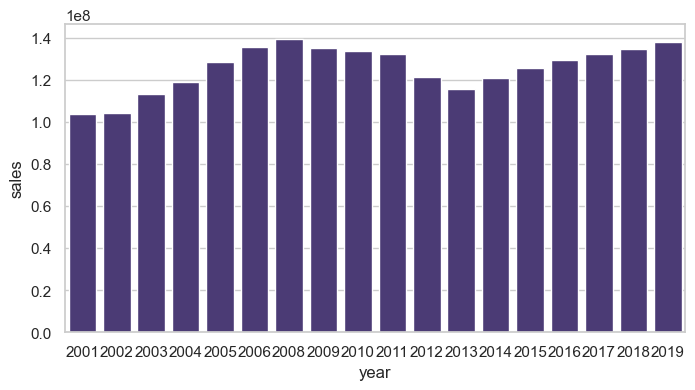

In [58]:
# we want to visualise how sales have grown by year
sns.set_theme(style = 'whitegrid', palette="viridis",rc={'figure.figsize':(8,4)})

yoy_sales = df_raw[['year', 'sales']].groupby('year').sum()
ax = sns.barplot(data=yoy_sales, x='year', y='sales', estimator=sum)

Insights: 
- **Available numbers**: Not all numbers come up in the dataset for every year. 
    - between 2001 and 2010, only 85000 nrs were offered. 
    - After 2011 there are still some values missing. For instance, in 2018, only 99855 out of 100000 nrs are listed. We'll need to manage this missing values. 
- **Series**: The amount of "series" issued every year has also changed since 2001. Each "series" consists of 100000 "billetes de lotería" (one per number), and every "billete" contains 10 "décimos de lotería". We'll need to normalise the sales by the total amount of "décimos" available for each nr in that year (the nr of series multiplied by 10). 
- **Total sales**: The total amount of sales has also changed over the years. It's interesting to see how the 2008 crisis might have affected lottery sales. We wonder if sth similar could have happened in 2020 as well (more data has been requested). Also: the year 2007 is missing for some reason. 

### Last digit first digit exploration

In [59]:
df_digits = df_raw[df_raw['year']>2010][['n', 'sales']].groupby('n').mean().reset_index()

# define new columns
df_digits["last"] = df_digits.index % 10
df_digits["first"] = df_digits.index // 10000
df_digits["last_2"] = df_digits.index % 100
df_digits["first_2"] = df_digits.index // 1000

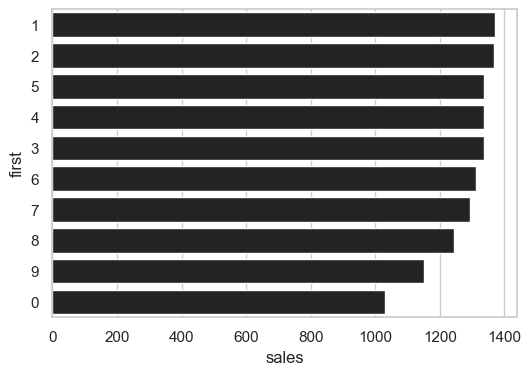

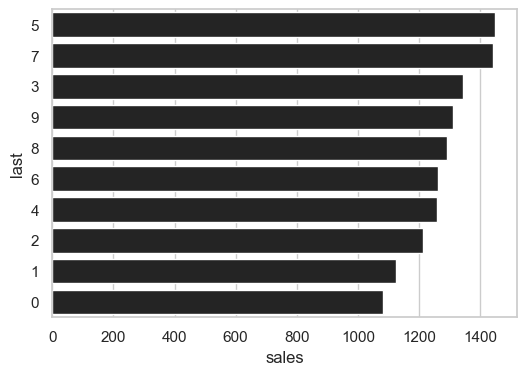

In [60]:
# plot sales distribution depending on the last or first digit

hbarplot(df_digits, ['first', 'last'], 'sales', height=4 )


In [61]:
def hbarplot(df, columns, target, height, crop = None):
    sns.set_theme(style = 'whitegrid', palette="gray", rc={'figure.figsize':(6,height)})
    for column in columns:
        temp_table = df.groupby(column).sum().sort_values(by='sales', ascending=False).reset_index()
        if crop == 'head':
            temp_table = temp_table.head(10)
        elif crop == 'tail':
            temp_table = temp_table.tail(10)
        sns.barplot(temp_table, x=target,y=column, orient = 'y', order=temp_table[column])
        plt.show()

    sns.set_theme(rc={'figure.figsize':(5,4)})

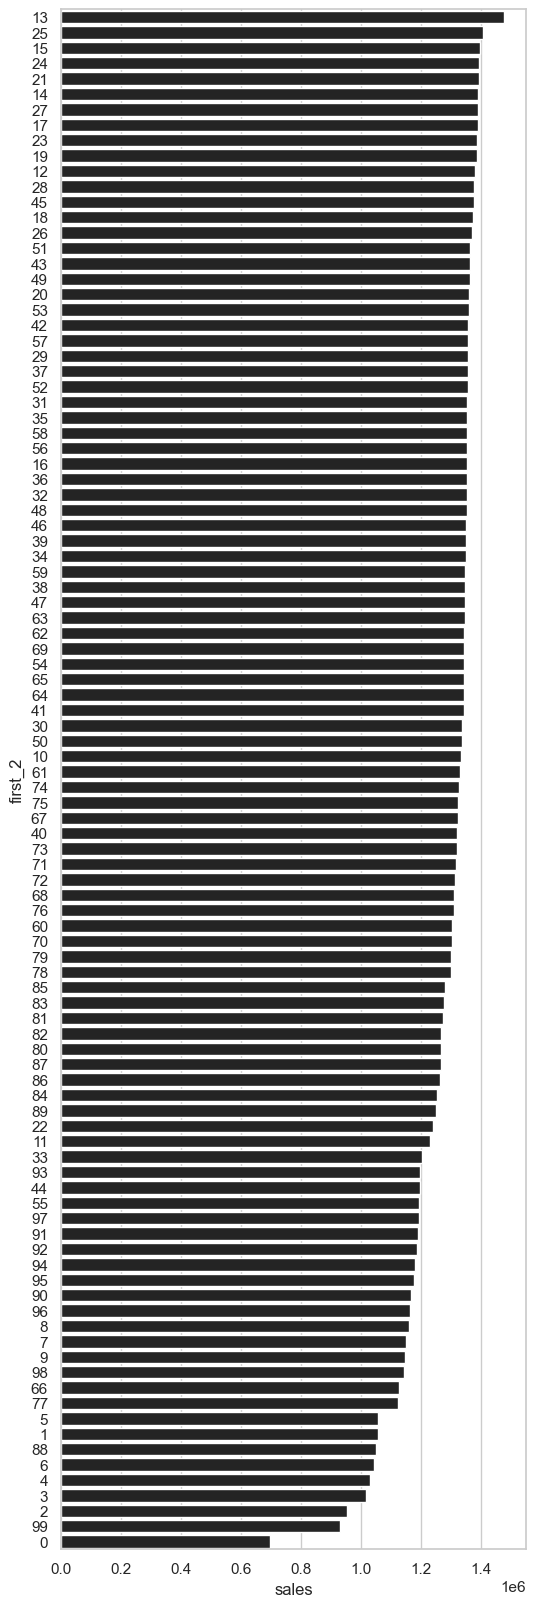

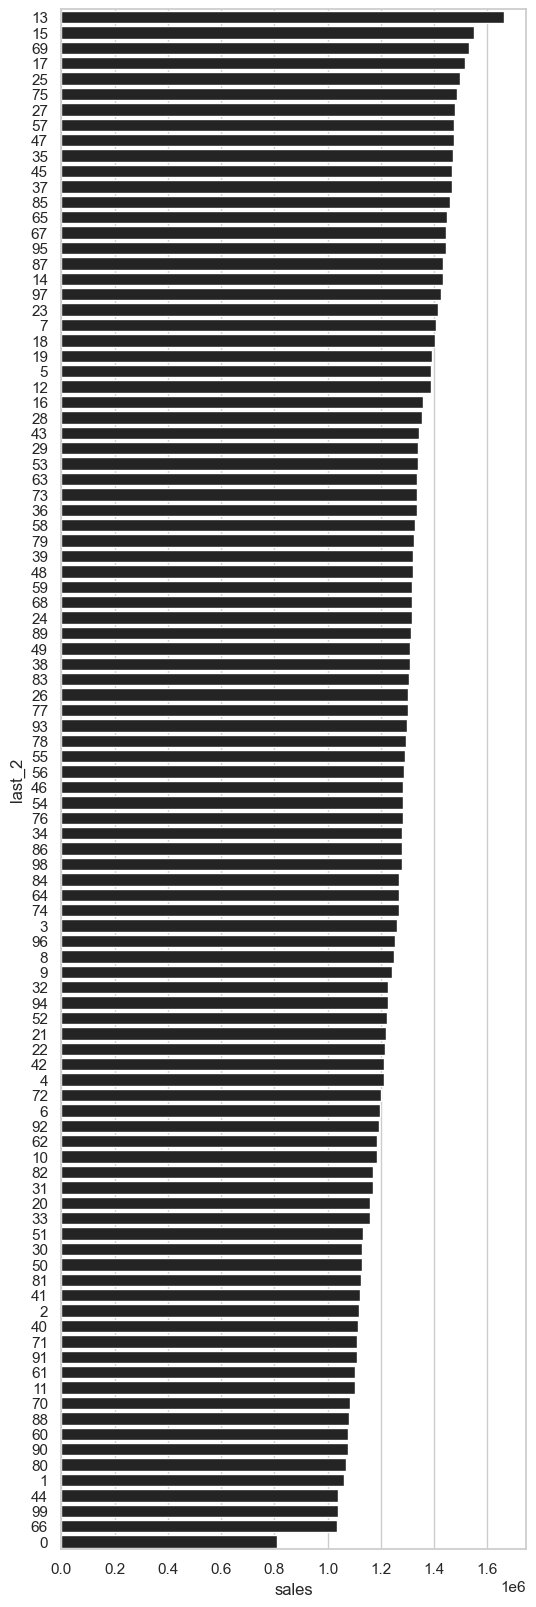

In [62]:
hbarplot(df_digits, ['first_2', 'last_2'], 'sales', height=20)

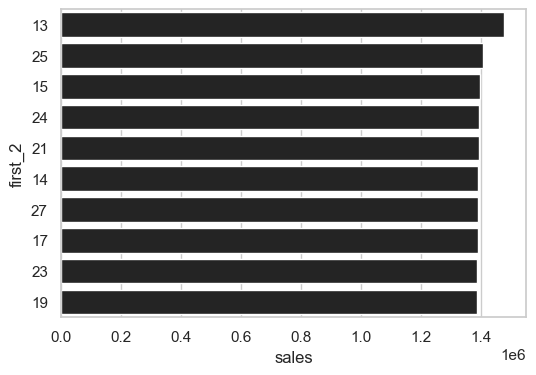

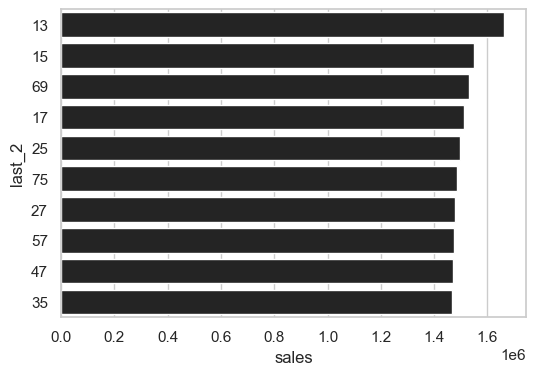

In [63]:
hbarplot(df_digits, ['first_2', 'last_2'], 'sales', height=4, crop = 'head')

## Data cleaning

### Normalise sales data: 

In [64]:
# First we'll pivot the dataframe
# We also want to normalise each year's sales so that the max value of sales = 1

df = normalise_sales(df_raw)

<Axes: xlabel='year', ylabel='sales'>

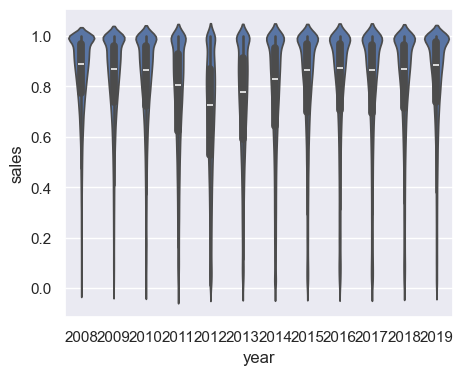

In [65]:
sns.violinplot(data=df[range(2008, 2020)].stack().reset_index().rename(columns={0:'sales'}), y='sales', x='year')


### Missing values:

There are few rows with nan values compared to the total (less than 0.5%). 
These Nan values could point to nrs that failed to sell any "décimos", or to an error in the csv. We'll fill them in with the avg value of sales from other years for that same nr. 

In [66]:
# We want to calculate the median, mean and std of each year's sales and fill with the median value of sales for that particular number

df = get_sales_stats(df)

# save sales data
df.to_csv('../data/lottery_nr_sales.csv')

### YoY correlation: 

<Axes: xlabel='year', ylabel='year'>

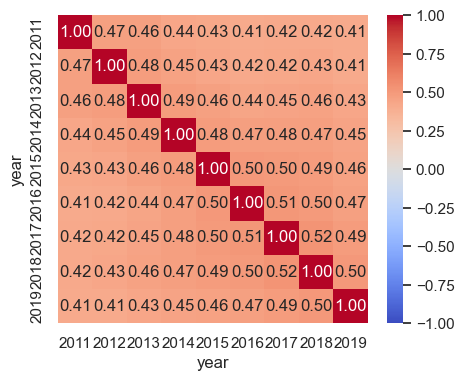

In [67]:
# let's explore the correlation matrix for the last 9 years (before 2011 not all the numbers were offered). 
sns.heatmap(df[list(range(2011, 2020))].corr(), annot = True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')

There seems to be some amount of correlation, although this is not perfect (there are some significant changes from year to year that do not depend entirely on the nr)

<Axes: xlabel='2011', ylabel='2017'>

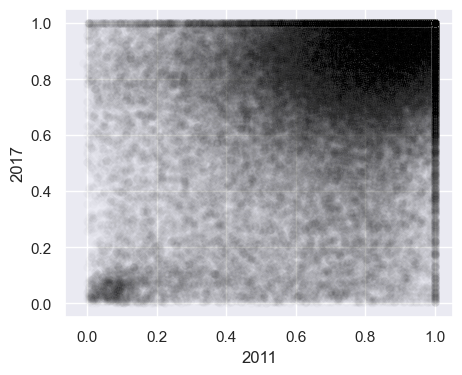

In [68]:
# Let's plot the scatter plot for a pair of years
sns.scatterplot(data=df, x=2011, y=2017, color = 'black', alpha=0.02)

It seems that some numbers (beautiful numbers) sell a lot consistently across years. 
Other numbers (ugly numbers) sell very little. 
But there's a lot of variability as well. We can use a kmeans to separate these groups. 

## Beauty metrics

Even if the results of the lottery are perfectly random, not all numbers add up the same amount of sales. We want to analyse why some numbers are perceived as more "beautiful" (or more "lucky"), and therefore are mores easily sold. 

These are some initial hypothesis: 

- Numbers that have repeated digits sell less. 
- Numbers that are part of a series (delta between 2 consecutive nrs is repeated) sell less. 
- Numbers that could be a date sell more. 
- Numbers taht start with 0 sell less. 
- Numbers that are odd sell more. 
- Numbers that end in 7 sell more. 
- Numbers that end in a prime number sell more. 
- Numbers that are perceived as more "random" (no clear pattern), sell more. 

In order to validate all these hypothesis, we will add new metrics to the df. 

In [89]:
beauty_metrics = Nr_properties()

# save beauty metrics to csv    
beauty_metrics.to_csv('../data/nr_beauty_metrics.csv', index=False)

## Variables exploration

In [70]:
features = pd.read_csv('../data/nr_beauty_metrics.csv', dtype={'str_n':str})
target = pd.read_csv('../data/lottery_nr_sales.csv')

df = features.merge(target, on='n')
df

,n,str_n,contains_13,ends_0,ends_00,ends_13,ends_15,ends_5,ends_69,ends_7,...,2013,2014,2015,2016,2017,2018,2019,median,mean,std
0,0,00000,False,True,True,False,False,False,False,False,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999938,0.000185
1,1,00001,False,False,False,False,False,False,False,False,...,0.999375,1.000000,0.999375,0.992727,0.998824,1.000000,1.000000,0.999444,0.998861,0.002337
2,2,00002,False,False,False,False,False,False,False,False,...,0.628750,0.690000,0.792500,0.991515,0.911176,0.947647,0.968235,0.915556,0.866153,0.130906
3,3,00003,False,False,False,False,False,False,False,False,...,0.730000,0.807500,0.816250,0.757576,0.869412,0.924118,1.000000,0.816250,0.831651,0.088662
4,4,00004,False,False,False,False,False,False,False,False,...,0.616250,0.927500,0.972500,0.690909,0.810000,0.970000,1.000000,0.810000,0.807030,0.172846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,99995,False,False,False,False,False,True,False,False,...,0.061875,0.557500,0.710000,0.292727,0.000000,0.077647,0.225530,0.225530,0.280385,0.254901
99996,99996,99996,False,False,False,False,False,False,False,False,...,0.026250,0.077500,0.136875,0.040606,0.027647,0.062353,0.144706,0.040606,0.065474,0.045795
99997,99997,99997,False,False,False,False,False,False,False,True,...,0.068750,0.692500,0.068750,0.446667,0.128971,0.132941,0.005882,0.128971,0.210756,0.235341
99998,99998,99998,False,False,False,False,False,False,False,False,...,0.046250,0.060625,0.104375,0.272727,0.052941,0.178824,0.036471,0.060625,0.104443,0.081261


In [71]:
df.drop('n', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 51 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   str_n                100000 non-null  object 
 1   contains_13          100000 non-null  bool   
 2   ends_0               100000 non-null  bool   
 3   ends_00              100000 non-null  bool   
 4   ends_13              100000 non-null  bool   
 5   ends_15              100000 non-null  bool   
 6   ends_5               100000 non-null  bool   
 7   ends_69              100000 non-null  bool   
 8   ends_7               100000 non-null  bool   
 9   ends_prime           100000 non-null  bool   
 10  is_odd               100000 non-null  bool   
 11  is_prime             100000 non-null  bool   
 12  odd_count            100000 non-null  int64  
 13  start_digit          100000 non-null  int64  
 14  starts_0             100000 non-null  bool   
 15  starts_00         

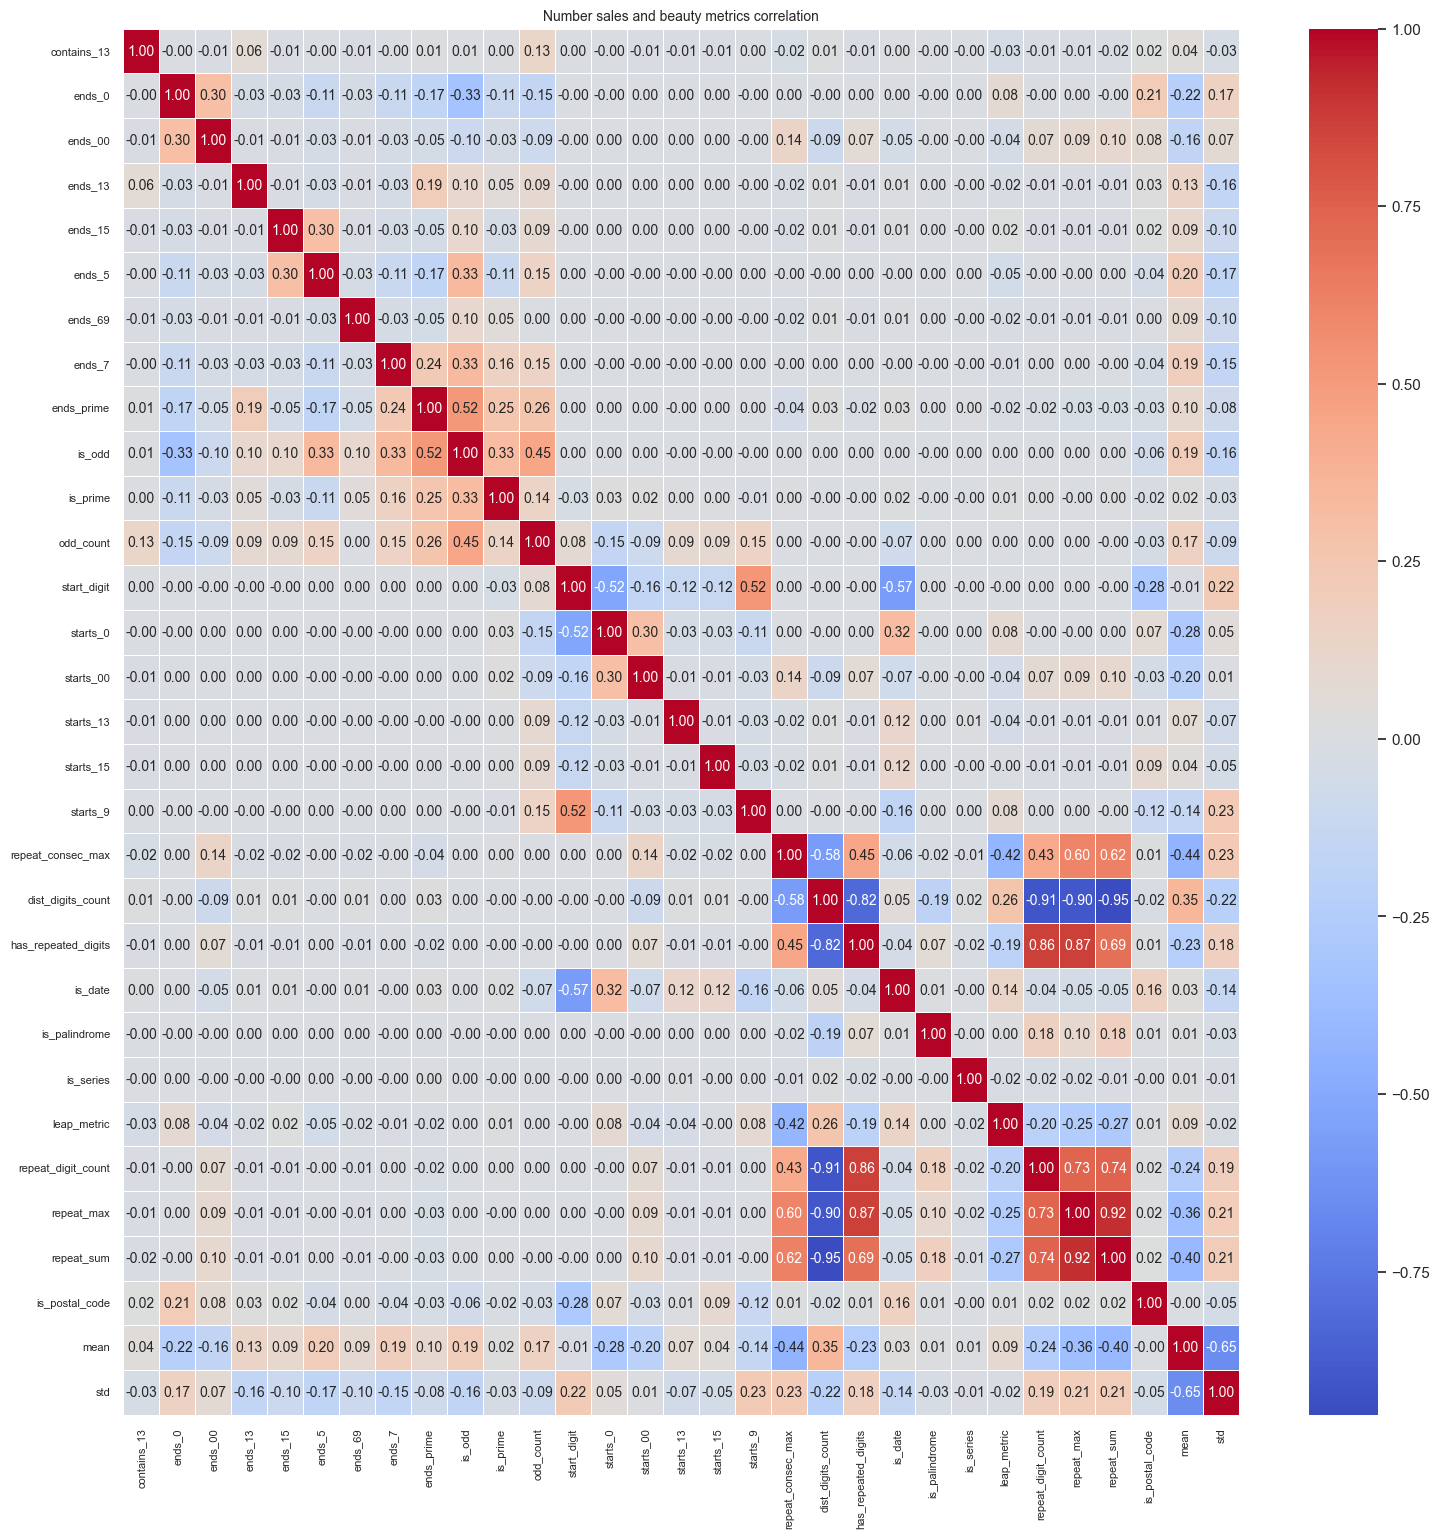

In [72]:
year_columns = [str(x) for x in list(range(2001, 2007))+list(range(2008, 2020))]

corr = df.drop(columns=(['str_n', 'median']+year_columns)).corr()

# heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(corr, annot=True,fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})  # "annot_kws" controla el tamaño de las anotaciones
plt.xticks(fontsize=8)  # Cambiar el tamaño de la fuente en las etiquetas del eje X
plt.yticks(fontsize=8)  # Cambiar el tamaño de la fuente en las etiquetas del eje Y
plt.title('Number sales and beauty metrics correlation', fontsize=10)

plt.show()

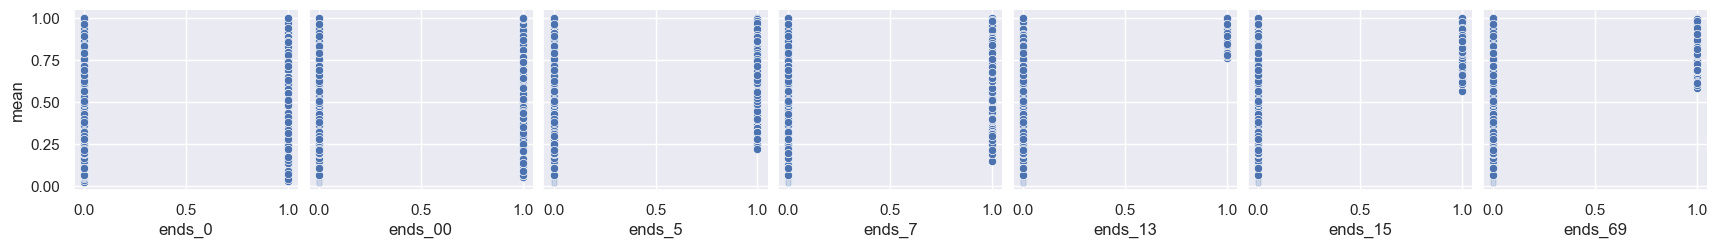

In [73]:
sns.pairplot(data=df,
            x_vars=['ends_0', 'ends_00', 'ends_5' , 'ends_7', 'ends_13', 'ends_15', 'ends_69'],
            y_vars=['mean'] 
            )

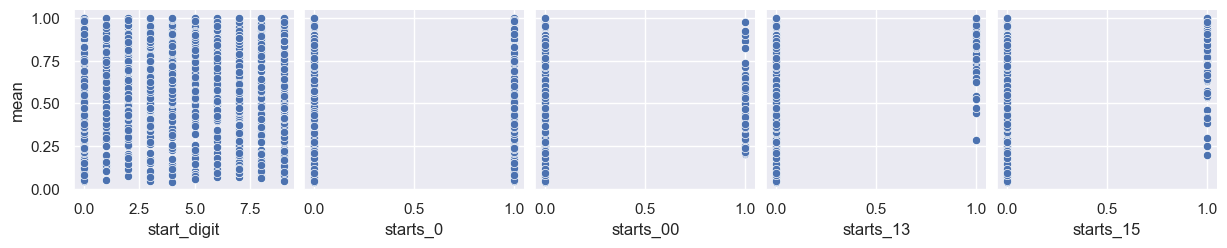

In [74]:
sns.pairplot(data=df.sample(10000),
            x_vars=['start_digit', 'starts_0', 'starts_00', 'starts_13', 'starts_15'],
            y_vars=['mean'] 
            )

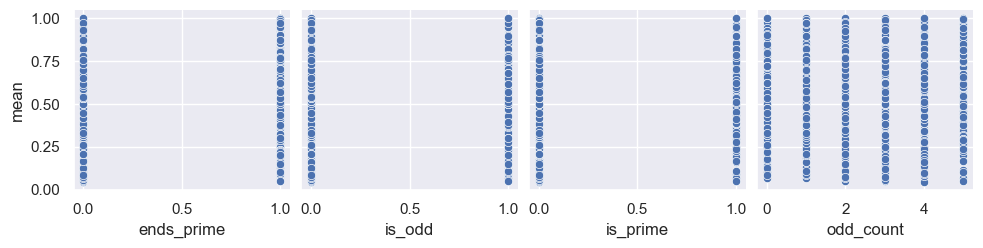

In [75]:
sns.pairplot(data=df.sample(10000),
            x_vars=['ends_prime', 'is_odd', 'is_prime', 'odd_count'],
            y_vars=['mean'] 
            )

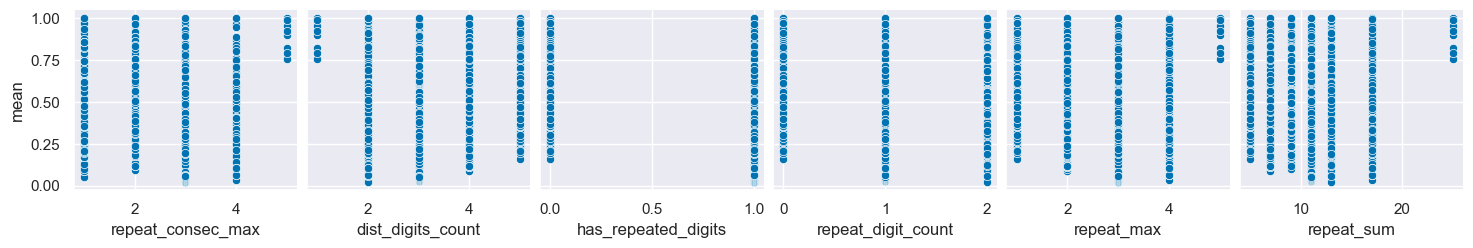

In [76]:
sns.set_theme(palette = 'colorblind')

sns.pairplot(data=df,
            x_vars=['repeat_consec_max', 'dist_digits_count', 'has_repeated_digits', 'repeat_digit_count', 'repeat_max', 'repeat_sum'],
            y_vars=['mean'] 
            )

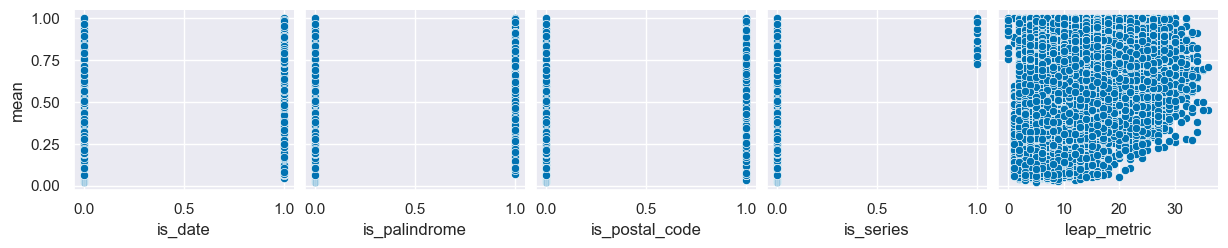

In [77]:
sns.set_theme(palette = 'colorblind')

sns.pairplot(data=df,
            x_vars=['is_date', 'is_palindrome', 'is_postal_code', 'is_series', 'leap_metric'],
            y_vars=['mean'] 
            )

<Axes: xlabel='std', ylabel='Count'>

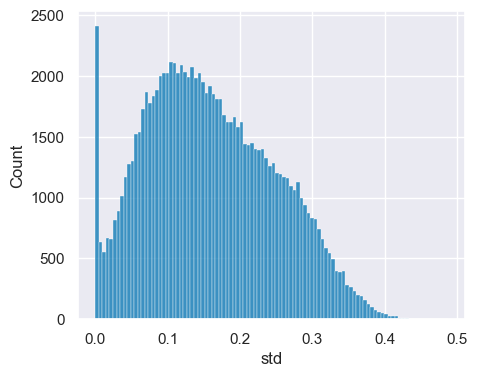

In [78]:
# How is the distribution of sales for each nr, is the std too big? 

sns.histplot(df['std'], bins=100)

# It seems that there's a bunch of numbers that always sell all the available series. These are our "beauty queens"
# The rest of the numbers have different std deviations, but the most usual value is around 0.05 -> this means, that the sales for a given number don't change a lot in different years. 
# The long tail indicates that some numbers may vary much more though, we could consider removing them from the dataset, or treat them as "noise"

In [79]:
# the numbers with high std indicate high variability: some years they get lots of sales. Other years they are not so popular. 
df[df['std'] >= 0.4]

,str_n,contains_13,ends_0,ends_00,ends_13,ends_15,ends_5,ends_69,ends_7,ends_prime,...,2013,2014,2015,2016,2017,2018,2019,median,mean,std
4700,04700,False,True,True,False,False,False,False,False,False,...,0.411875,0.031875,0.286250,1.000000,1.000000,1.000000,1.000000,0.411875,0.568827,0.421904
5521,05521,False,False,False,False,False,False,False,False,False,...,0.312500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.728858,0.410582
7130,07130,True,True,False,False,False,False,False,False,False,...,0.038125,0.031250,0.815625,0.677576,1.000000,1.000000,0.658824,0.660000,0.544847,0.407002
8442,08442,False,False,False,False,False,False,False,False,False,...,0.603125,0.025000,1.000000,0.027879,1.000000,0.197647,0.682353,0.197647,0.415729,0.409108
9240,09240,False,True,False,False,False,False,False,False,False,...,0.768125,0.018750,0.997500,0.127273,0.851765,1.000000,0.892941,0.768125,0.565644,0.414148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99300,99300,False,True,True,False,False,False,False,False,False,...,0.000000,0.061250,1.000000,1.000000,0.574118,0.133529,0.146471,0.146471,0.349547,0.403550
99302,99302,False,False,False,False,False,False,False,False,False,...,0.030000,0.030000,0.946250,0.844242,0.723529,0.534706,1.000000,0.534706,0.496464,0.406360
99341,99341,False,False,False,False,False,False,False,False,True,...,0.638750,0.061250,0.068750,1.000000,0.947059,0.171176,0.985294,0.638750,0.580006,0.419343
99351,99351,False,False,False,False,False,False,False,False,False,...,0.778125,1.000000,0.177500,0.054545,0.648824,0.095882,0.770588,0.648824,0.499990,0.405126


In [80]:
# What happens when a nr wins the lottery? Do their sales chagne in some obvious way?
df[df.index.isin([3347, 71198, 66513, 79140, 13437])]

# if there are any changes these are not obvious... and these are only 5 numbers. We won't use this information for now. 

,str_n,contains_13,ends_0,ends_00,ends_13,ends_15,ends_5,ends_69,ends_7,ends_prime,...,2013,2014,2015,2016,2017,2018,2019,median,mean,std
3347,03347,False,False,False,False,False,False,False,True,True,...,0.888125,0.886875,0.811250,0.635152,0.573529,0.586471,0.996471,0.851111,0.794517,0.156223
13437,13437,False,False,False,False,False,False,False,True,True,...,0.948125,1.000000,1.000000,1.000000,1.000000,0.928824,1.000000,1.000000,0.977439,0.029283
66513,66513,False,False,False,True,False,False,False,False,True,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
71198,71198,False,False,False,False,False,False,False,False,False,...,0.463125,0.728125,0.889375,0.817576,0.873529,1.000000,1.000000,0.866667,0.798834,0.186659
79140,79140,False,True,False,False,False,False,False,False,False,...,0.601875,0.900625,0.706250,0.793333,0.837059,0.947647,0.588824,0.706250,0.712846,0.184465


<Axes: xlabel='mean', ylabel='Count'>

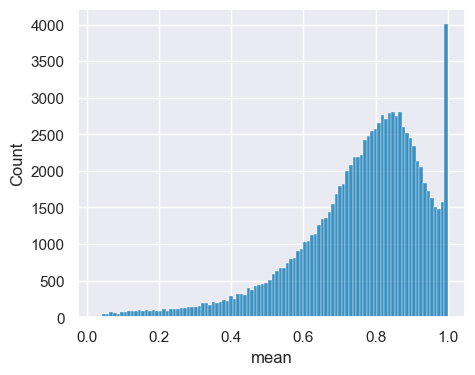

In [81]:
sns.histplot(df['mean'], bins=100)


In [82]:
def hbarplot(df, columns, target, height, crop = None):
    sns.set_theme(style = 'whitegrid', palette="gray", rc={'figure.figsize':(6,height)})
    for column in columns:
        temp_table = df[[column, target]].groupby(column).mean().sort_values(by=target, ascending=False).reset_index()
        if crop == 'head':
            temp_table = temp_table.head(10)
        elif crop == 'tail':
            temp_table = temp_table.tail(10)
        sns.barplot(temp_table, x=target,y=column, orient = 'y', order=temp_table[column])
        plt.show()

    sns.set_theme(rc={'figure.figsize':(5,4)})

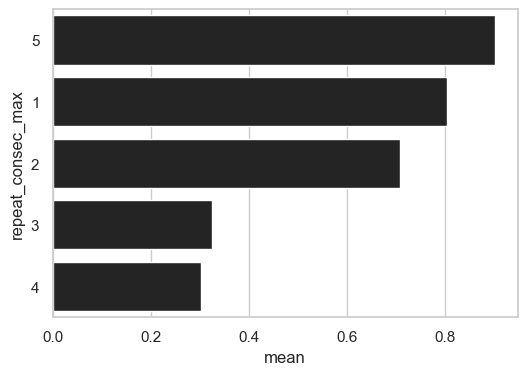

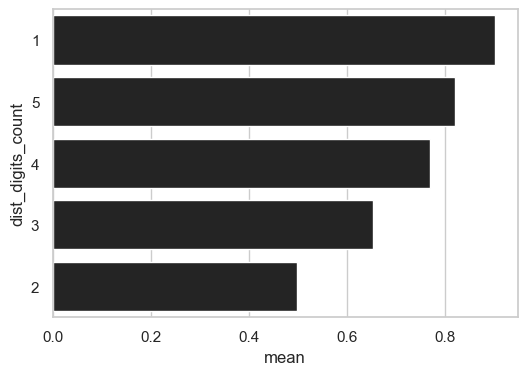

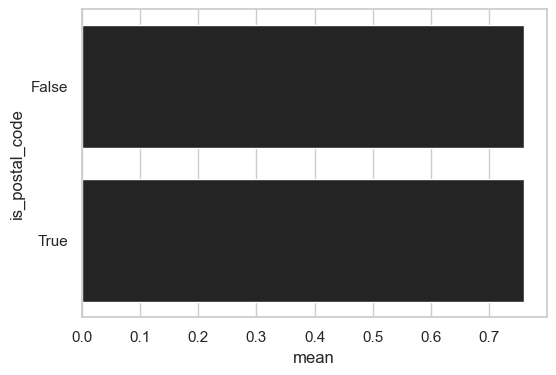

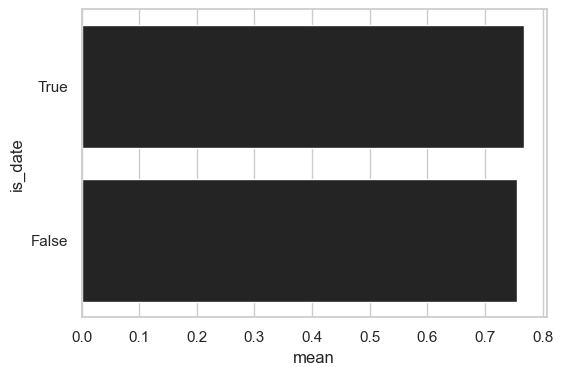

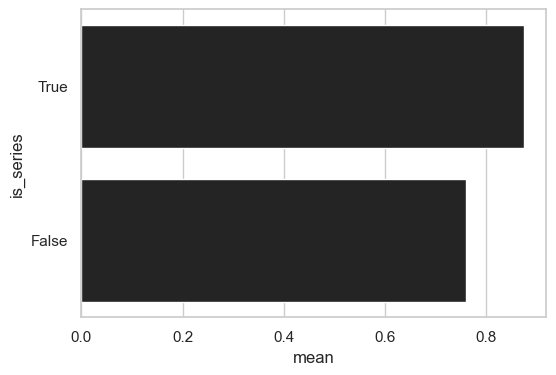

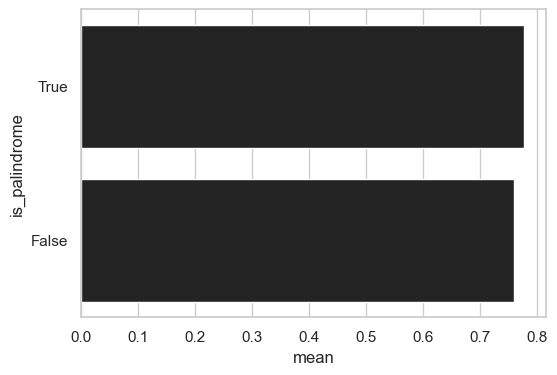

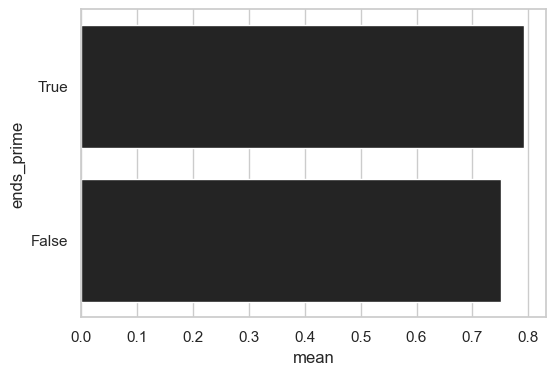

In [83]:
hbarplot(df, ['repeat_consec_max', 'dist_digits_count', 'is_postal_code', 'is_date', 'is_series', 'is_palindrome', 'ends_prime'], 'mean', height=4 )

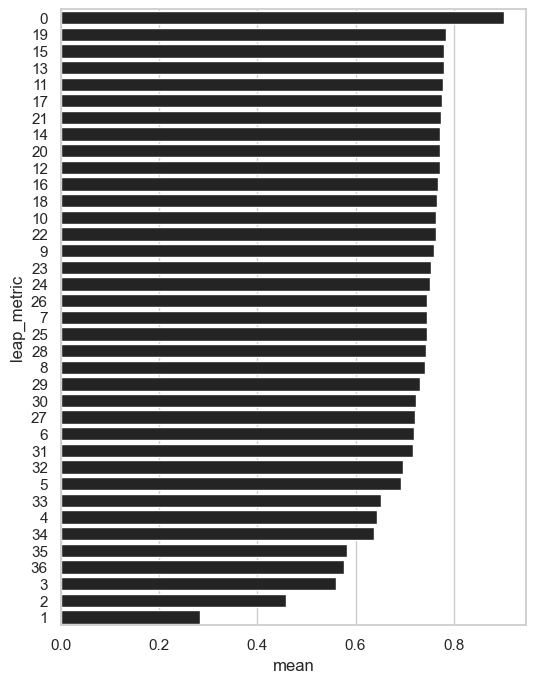

In [42]:
hbarplot(df, ['leap_metric'], 'mean', height=8 )


In [86]:
df[df['starts_13']==True]['mean'].mean()

np.float64(0.8783479469119297)